&#8592; Go back to [Querying and downloading cartographic material from loc.gov](maps-downloading-querying.ipynb) 

# Analyzing and visualizing cartographic metadata from loc.gov

<p class="lead">Table of Contents</p>

- [This notebook](#This-notebook)
- [1. Required Prep: Install and import all of the Python modules we'll need](#1.-Required-Prep:-Install-and-import-all-of-the-Python-modules-we'll-need)
- [2. Query for list of records](#2.-Query-for-list-of-records)
- [3. Harvest the metadata](#3.-Harvest-the-metadata)
- [4. Basic metadata analysis](#4.-Basic-metadata-analysis)
- [5. Metadata charts](#5.-Metadata-charts)
- [6. Metadata maps and Wikidata](#6.-Metadata-maps-and-Wikidata)

<div class="alert alert-info">
<p class="lead">More Resources</p>
    
Other Jupter notebooks and examples from the Library of Congress can be found at <a href="https://labs.loc.gov/lc-for-robots/#try">LC for Robots</a>. 


</div>

## This notebook
This notebook is part two of a series of Jupyter notebooks exploring how to computationally access, retrieve, and analyze cartographic collections on loc.gov. 

This noteobok demonstrates methods to:

- retrieve metadata associated with files downloaded in [Querying and downloading cartographic material from loc.gov](maps-downloading-querying.ipynb) 
- retrieve metadata associated with the Sanborn collection
- analyze and visualize metadata

## 1. Required Prep: Install and import all of the Python modules we'll need

Plotly, which we'll be using in this notebook, will need to be installed on your computer. Outside this Jupyter notebook, open a terminal window and install Plotly. One of the easiest ways of installing modules is by using pip, as in this tutorial from W3C: https://www.w3schools.com/python/python_pip.asp. If you have a preferred package manager, you may use that.

If you run the cell below and encounter any errors, be sure to check that all the packages are installed.

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 
    
import modules. 
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;

</div>

In [1]:
import time
import re
import json
from urllib.request import urlopen
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## 2. Query for list of records

If you'd just finished the previous notebook, [Querying and downloading cartographic material from loc.gov](maps-downloading-querying.ipynb) , then you've just downloaded a set of GIF images. These images represent all of the Sanborn Fire Insurance maps for 19th century towns named "Springfield". If you haven't completed the previous notebook, that's ok. It's not required.

Let's retrieve the metadata associated with these files, such as titles, publication dates, and locations. We'll save it as a CSV alongside your downloaded files, so you can refer back to it later. 

If you were writing your own code, you would probably want to get the metadata at the same time you download the files, to minimize API requests and save time. But for the purposes of our demo, we'll make new API requests to get the metadata.

If you remember, our search query was saved into the `searchURL` variable as https://www.loc.gov/collections/sanborn-maps/?dates=1800/1899&fa=location:springfield. Let's recreate that. 

We also created a `get_item_ids` function, to get the IDs of our query results. Let's recreate that as well.

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 
    
save our API query to the `searchURL` variable and create the `get_item_ids` function.
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;

</div>

In [2]:
searchURL = 'https://www.loc.gov/collections/sanborn-maps/?dates=1800/1899&fa=location:springfield'

def get_item_ids(url, items=[], conditional='True'):
    # Check that the query URL is not an item or resource link.
    exclude = ["loc.gov/item","loc.gov/resource"]
    if any(string in url for string in exclude):
        raise NameError('Your URL points directly to an item or '
                        'resource page (you can tell because "item" '
                        'or "resource" is in the URL). Please use '
                        'a search URL instead. For example, instead ' 
                        'of \"https://www.loc.gov/item/2009581123/\", '
                        'try \"https://www.loc.gov/maps/?q=2009581123\". ') 
    
    # Request pages of 100 results at a time
    params = {"fo": "json", "c": 100, "at": "results,pagination"}
    call = requests.get(url, params=params)
    # Check that the API request was successful
    if (call.status_code==200) & ('json' in call.headers.get('content-type')):
        data = call.json()
        results = data['results']
        for result in results:
            # Filter out anything that's a colletion or web page
            filter_out = ("collection" in result.get("original_format")) \
                    and ("web page" in result.get("original_format")) \
                    and (eval(conditional)==False)
            if not filter_out:
                # Get the link to the item record
                if result.get("id"):
                    item = result.get("id")
                    # Filter out links to Catalog or other platforms
                    if item.startswith("http://www.loc.gov/item"):
                        items.append(item)
        # Repeat the loop on the next page, unless we're on the last page. 
        if data["pagination"]["next"] is not None: 
            next_url = data["pagination"]["next"]
            get_item_ids(next_url, items, conditional)

        return items
    else:
        print('There was a problem. Try running the cell again, or check your searchURL.')

When we run a search query, we get a significant amount of metadata about each of the results. However, it's not the full metadata about each item. For example, it doesn't include `location` metadata. To get the full metadata, after we run our query we must then request each of the results' item records. 

We'll run the `get_item_ids` function above, which runs our initial search query. It will save a list of item ids to the `ids` variable. Later, we'll get the full item records and metadata for each atlas. 

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 

generate a list of Springfield atlas records, and save their IDs to the variable `ids`. The cell will print out the number of results. This is the number of atlases downloaded in the last Jupyter notebook, and it is the number of rows our metadata CSV spreadsheet will have. We can use the `len` function to tell us the length of `ids`.

&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [3]:
ids = get_item_ids(searchURL, items=[])
len(ids)

22

# 3. Harvest the metadata

Now we'll write a function to request the full item record for each of our 22 search results. This function will fetch each item record as JSON, and retrieve selected fields we specify. For this example, let's say that we want the following metadata fields:
- title
- notes
- location
- date
- item ID

In order to know how to write the function, we'll need to understand how an item record is structured. 

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 

look at how the metadata in an item record is structured, by looking at the first item in `ids`.

&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [4]:
# Get the id of the first item in our list
first_result = ids[0]
# Make the API call.
item = requests.get(first_result, params = {"fo": "json"})
# Tell Python to read the result as JSON.
item_json = item.json()
# Get the "item" section of the JSON record.
item_metadata = item_json['item']

print('---Metadata for the query\'s first result----\n')
print('Title: ')
print(item_metadata['title'])
print('\nNotes: ')
print(item_metadata['notes'])
print('\nLocation: ')
print(item_metadata['location'])
print('\nDate: ')
print(item_metadata['date'])
print('\nItem ID (URL): ')
print(item_metadata['id'])
print('\nView item record json in your web browser: ')
print(item_metadata['id']+'?fo=json')

---Metadata for the query's first result----

Title: 
Sanborn Fire Insurance Map from Springfield, Sangamon County, Illinois.

Notes: 
[' Feb 1884. ', ' 15. ']

Location: 
[{'illinois': 'https://www.loc.gov/search/?fa=location:illinois&fo=json'}, {'sangamon county': 'https://www.loc.gov/search/?fa=location:sangamon+county&fo=json'}, {'springfield': 'https://www.loc.gov/search/?fa=location:springfield&fo=json'}]

Date: 
1884-02

Item ID (URL): 
http://www.loc.gov/item/sanborn02163_001/

View item record json in your web browser: 
http://www.loc.gov/item/sanborn02163_001/?fo=json


<div class="alert alert-info">
<p class="lead">Tip</p>
    
Most web browsers have built-in JSON viewers. Try copying the link above labelled "View item record json in your web browser" into various browsers, to see how they each visualize JSON. 

You can also view the full JSON item record in this Jupyter notebook by running `item_metadata`.

</div>

-------
<p class="lead">How is the metadata structured?</p>

Notice in the output above that the `Notes` and `Location` values are in square brackets: 

```
Notes: 
[' Feb 1884. ', ' 15. ']

Location: 
[{'illinois': 'https://www.loc.gov/search/?fa=location:illinois&fo=json'}, {'sangamon county': 'https://www.loc.gov/search/?fa=location:sangamon+county&fo=json'}, {'springfield': 'https://www.loc.gov/search/?fa=location:springfield&fo=json'}]
```

This indicates that these values are Python lists, containing multiple values. Each value in the list is separated by a comma. In `Notes`, there are two values in the list, and each is surrounded by single quotes. (Notes is a general field that can contain a range of information. For Sanborns, it is used to hold publication date and number of sheets.)

`Location` is a little more complicated. It's a list, but each item in the list is a Python dictionary. The example `Location` above is a list of three dictionaries. The first one looks like this:

```
{'illinois': 'https://www.loc.gov/search/?fa=location:illinois&fo=json'}
```

Curly brackets are used around dictionaries; square brackets are around lists. This dictionary has a single "key:value" pair. The key is "illinois". The value is a URL. The URL isn't useful for our purposes. For this item, `Location` has three dictionaries, and their keys are: "illinois", "sangamon county", and "springfield". This tells us that the atlas is in Springfield, Sangamon County, Illinois. Notice that the metadata itself doesn't indicate any hierarchy between the locations.

When we harvest our metadata, we're going to save it into a CSV file. For this CSV, any fields that contain lists will be split into muiltple columns. For location, we'll get the keys (like "illinois", "sangamon county", "springfield") but we'll design our code to skip the URLs. 

<p class="lead">Let's create a function that will harvest item record metadata into a CSV.</p>

The function will: 
- take our list of items (`ids`)
- use the API to request each item record as JSON
- extract the metadata fields we want from each record
- add those fields to something Python calls a "dataframe"
- save the dataframe as a CSV file

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 

create function `get_metadata_from_ids` for harvesting and saving our metadata to a CSV file. 

&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>


In [5]:
def get_metadata_from_ids(ids):
    # List the fields we want.
    fields = ['title', 'notes','location','date']
    # Create a blank dataframe
    metadata_dataframe = pd.DataFrame()
    # Iterate through the IDs in our list
    for id_url in ids:
        print('Getting metadata for: '+id_url)
        # Create a blank dictionary for each ID. 
        item_dictnry = {}
        # Add the item ID to the dictionary.
        item_dictnry['id'] = id_url
        params = {"fo": "json"}
        try:
            # Make the API call for item record
            item = requests.get(id_url, params=params)
            item_json = item.json()
            item_metadata = item_json['item']
            # Get the number of pages
            try:
                pages = len(item_json['resources'][0]['files'])
            except:
                pages = None
            item_dictnry['page_count'] = pages
            # Iterate through our list of desired fields
            for field in fields:
                # Check if the field is a list
                field_type = type(item_metadata[field])
                # If the field is a list, get all values from it
                if field_type==list:
                    # Check how long the list is
                    number_cols = len(item_metadata[field])
                    # Make a numerical list from the length
                    number_range = range(number_cols)
                    # For each place in the list:
                    for i in number_range:
                        # Get the place number as a string
                        i_str = str(i)
                        # If field is location, get keys from the dictionary
                        if field == 'location':
                            try:
                                placename = item_metadata[field][i].keys()
                                item_dictnry[field+i_str] = list(placename)[0]
                            except:
                                item_dictnry[field+i_str] = None       
                        # If the field isn't location, just get the list values
                        else:
                            try:
                                item_dictnry[field+i_str] = \
                                    item_metadata[field][i]
                            except:
                                item_dictnry[field+i_str] = None  
                #If the field isn't a list, get the field's value. 
                else:
                    try:
                        item_dictnry[field] = item_metadata[field]
                    except:
                        item_dictnry[field] = None                      

        #If anything goes wrong, make a CSV row of None values.
        except:
            for field in fields:
                item_dictnry[field] = None
        # Parse out the last section of the id URL
        item_dictnry['id_simplified'] = item_dictnry['id'].split('/')[-2] 
        # Add each item to the end of the dataframe
        metadata_dataframe = metadata_dataframe.append(
                item_dictnry, ignore_index=True
            ).copy()
        # Pause before making an API call for the next item.
        time.sleep(5)
    # Function output is the dataframe.
    return metadata_dataframe

<p class="lead">Let's run the function above. </p>

The function will create a Python dataframe of our metadata. A dataframe is like a super-powered table for data calculation and analysis. We'll save that dataframe to a CSV file. The CSV file will be saved in the `saveTo` folder that you specify below. The filename will be `metadata.csv`.

<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 

run the function `get_metadata_from_ids` and save the results to a CSV named `metadata.csv` into the folder you specify in the `saveTo` variable.

Be sure to edit `saveTo` to point to a folder on your computer.

 
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;

</div>

In [6]:
saveTo = 'C:/Users/rtrent/jupyter-notebooks/sanborn-images/'

metadata_dataframe = get_metadata_from_ids(ids)
metadata_dataframe.to_csv(saveTo + '/metadata.csv')
metadata_dataframe

Getting metadata for: http://www.loc.gov/item/sanborn02163_001/
Getting metadata for: http://www.loc.gov/item/sanborn02163_002/
Getting metadata for: http://www.loc.gov/item/sanborn02163_003/
Getting metadata for: http://www.loc.gov/item/sanborn03245_001/
Getting metadata for: http://www.loc.gov/item/sanborn03245_002/
Getting metadata for: http://www.loc.gov/item/sanborn03245_003/
Getting metadata for: http://www.loc.gov/item/sanborn03858_001/
Getting metadata for: http://www.loc.gov/item/sanborn03858_002/
Getting metadata for: http://www.loc.gov/item/sanborn04392_001/
Getting metadata for: http://www.loc.gov/item/sanborn04392_002/
Getting metadata for: http://www.loc.gov/item/sanborn04881_001/
Getting metadata for: http://www.loc.gov/item/sanborn04881_002/
Getting metadata for: http://www.loc.gov/item/sanborn04881_003/
Getting metadata for: http://www.loc.gov/item/sanborn04881_004/
Getting metadata for: http://www.loc.gov/item/sanborn06900_001/
Getting metadata for: http://www.loc.gov

,date,id,id_simplified,location0,location1,location2,notes0,notes1,page_count,title,notes2,location3
0,1884-02,http://www.loc.gov/item/sanborn02163_001/,sanborn02163_001,illinois,sangamon county,springfield,Feb 1884.,15.,15.0,"Sanborn Fire Insurance Map from Springfield, S...",NaN,NaN
1,1890-07,http://www.loc.gov/item/sanborn02163_002/,sanborn02163_002,illinois,sangamon county,springfield,Jul 1890.,26.,26.0,"Sanborn Fire Insurance Map from Springfield, S...",NaN,NaN
2,1896,http://www.loc.gov/item/sanborn02163_003/,sanborn02163_003,illinois,sangamon county,springfield,1896.,81.,81.0,"Sanborn Fire Insurance Map from Springfield, S...",Map of congested district. Bound.,NaN
3,1886-08,http://www.loc.gov/item/sanborn03245_001/,sanborn03245_001,kentucky,springfield,washington county,Aug 1886.,2.,2.0,"Sanborn Fire Insurance Map from Springfield, W...",NaN,NaN
4,1893-02,http://www.loc.gov/item/sanborn03245_002/,sanborn03245_002,kentucky,springfield,washington county,Feb 1893.,2.,2.0,"Sanborn Fire Insurance Map from Springfield, W...",NaN,NaN
5,1898-10,http://www.loc.gov/item/sanborn03245_003/,sanborn03245_003,kentucky,springfield,washington county,Oct 1898.,3.,3.0,"Sanborn Fire Insurance Map from Springfield, W...",NaN,NaN
6,1886,http://www.loc.gov/item/sanborn03858_001/,sanborn03858_001,hampden county,massachusetts,springfield,1886.,35.,35.0,"Sanborn Fire Insurance Map from Springfield, H...",Bound.,NaN
7,1896,http://www.loc.gov/item/sanborn03858_002/,sanborn03858_002,hampden county,massachusetts,springfield,1896.,85.,93.0,"Sanborn Fire Insurance Map from Springfield, H...",6 skeleton maps.,NaN
8,1894-06,http://www.loc.gov/item/sanborn04392_001/,sanborn04392_001,brown county,minnesota,springfield,Jun 1894.,3.,3.0,"Sanborn Fire Insurance Map from Springfield, B...",NaN,NaN
9,1899-12,http://www.loc.gov/item/sanborn04392_002/,sanborn04392_002,brown county,minnesota,springfield,Dec 1899.,3.,3.0,"Sanborn Fire Insurance Map from Springfield, B...",NaN,NaN


<div class="alert alert-info">
<p class="lead">Tip</p>
    
When the cell above finishes running, scroll down to the bottom where you will see the `metadata_dataframe` displayed.

</div>


# 4. Basic metadata analysis
Now you have a CSV spreadsheet of metadata. If you completed the previous Jupyter notebook, you also have image files for these atlases downloaded to your computer (we'll assume for our purposes that you completed that notebook, but it's ok if you haven't). 

All of the information in that CSV is also at hand in this Jupyter notebook, in what's called a "dataframe". Dataframes come with the "Pandas" Python library, and you can do lots of things with dataframes that you can't easily do with dictionaries or lists. 

In the last notebook, each of your image files was downloaded into a folder on your computer. These folders are named according to the ID of each item. 

For example, you might have a folder called "sanborn02163_001", containing a GIF image file for each page. These images belong to a Sanborn atlas with the id "sanborn02163_001", which can be found online at https://loc.gov/item/sanborn02163_001

Using our dataframe of metadata, we can quickly pull up basic metadata about the atlas in the sanborn02163_001 folder, like location and date. We'll do this by looking for the string 'sanborn02163_001' in the `id_simplified` column.

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 

look for metadata about the downloaded atlas `sanborn02163_001`. You can change "sanborn02163_001" below for any other atlas id (aka, folder) that you've just downloaded.

&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [7]:
item_id = 'sanborn02163_001'
metadata_dataframe[metadata_dataframe['id_simplified']==item_id]

,date,id,id_simplified,location0,location1,location2,notes0,notes1,page_count,title,notes2,location3
0,1884-02,http://www.loc.gov/item/sanborn02163_001/,sanborn02163_001,illinois,sangamon county,springfield,Feb 1884.,15.,15.0,"Sanborn Fire Insurance Map from Springfield, S...",NaN,NaN


---------
<p class="lead">Found!</p> 

We can see that "sanborn02163_001" is a map of Springfield in Sangamon County, Illinois from February 1884. It has 15 sheets. (The number of sheets is in the `notes` field, and we also calculated it from the number of files in the `resource` field.)

Did we download any other atlases from the same Springfield in Sangamon County? 

Let's see. We'll look in our dataframe for rows where the strings 'illinois', 'sangamon county', and 'springfield'  appear in any of the location columns (alternatively, we could also search using the `title` field, but we'll stick with the `location` field for now.)

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 

look for any other atlases we've downloaded for Springfield, Sangamon County, Illinois

&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>


In [8]:
#List of location terms we want to find
look_for = ['illinois','sangamon county','springfield']
#List of columns to look in
look_in = ['location0','location1','location2']
# Create a new dataframe by looking at the values in all of the
# "look_in" columns and extracting all rows where that value is 
# in the list of "look_for" terms.

search_metadata = metadata_dataframe[
    metadata_dataframe[look_in].isin(look_for).all(axis=1)
]
search_metadata

,date,id,id_simplified,location0,location1,location2,notes0,notes1,page_count,title,notes2,location3
0,1884-02,http://www.loc.gov/item/sanborn02163_001/,sanborn02163_001,illinois,sangamon county,springfield,Feb 1884.,15.,15.0,"Sanborn Fire Insurance Map from Springfield, S...",NaN,NaN
1,1890-07,http://www.loc.gov/item/sanborn02163_002/,sanborn02163_002,illinois,sangamon county,springfield,Jul 1890.,26.,26.0,"Sanborn Fire Insurance Map from Springfield, S...",NaN,NaN
2,1896,http://www.loc.gov/item/sanborn02163_003/,sanborn02163_003,illinois,sangamon county,springfield,1896.,81.,81.0,"Sanborn Fire Insurance Map from Springfield, S...",Map of congested district. Bound.,NaN


<p class="lead">What if we want to analyze our overall results?</p>

For example, what is the average number of pages in the atlases we downloaded?

Pandas and Numpy (another Python module) offer many functions for running calculations on data in dataframes. Here, we'll use a simple one built into Pandas: the `.describe()` function. Used on the `page_count` column, `.describe()` can give us information such as:

- the average number of pages in the Sanborn map atlases we've downloaded
- the largest number of pages in any atlas we've downloaded
- the smallest number of pages in any atlas we've downloaded
- standard deviation of page counts

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 

get a summary of the number of pages in the atlases we've downloaded (min, max, and mean).

&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>


In [9]:
print('Smallest number of pages of a downloaded Sanborn:')
print(metadata_dataframe.page_count.describe()['min'])
print('Largest number of pages of a downloaded Sanborn:')
print(metadata_dataframe.page_count.describe()['max'])
print('Average number of pages (mean) of the downloaded Sanborns:')      
print(metadata_dataframe.page_count.describe()['mean'])

Smallest number of pages of a downloaded Sanborn:
2.0
Largest number of pages of a downloaded Sanborn:
93.0
Average number of pages (mean) of the downloaded Sanborns:
21.681818181818183


# 5. Metadata charts

<p class="lead">We can also visualize our results.</p>

For example, we can analyze dates.

Using a Python module called `matplotlib`, we can chart the frequency of atlases published, by year.

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 
chart the downloaded atlases by publication year.  
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

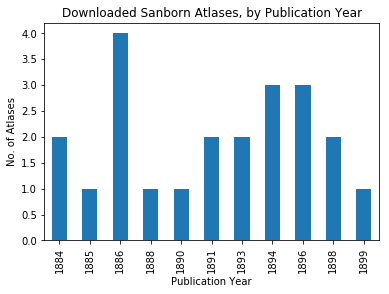

In [10]:
#Create a column from "date" that only includes the year.
metadata_dataframe['year'] = metadata_dataframe['date'].str[:4]
#Tell python to interpret that column as a datetime.
metadata_dataframe['year'] = metadata_dataframe['year']\
    .astype("datetime64[ns]")
#Create the display
visualize = metadata_dataframe.year.groupby(
        metadata_dataframe['year'].dt.year
    ).count()
visualize.plot(kind="bar")
plt.title('Downloaded Sanborn Atlases, by Publication Year')
plt.xlabel('Publication Year')
plt.ylabel('No. of Atlases')
plt.show()

<p class="lead">Or we could chart how many pages are in each atlas</p>

<div class="alert alert-success">
<p class="lead"> Run the next cell to: </p> 
    
chart the downloaded atlases by number of pages per atlas.  
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

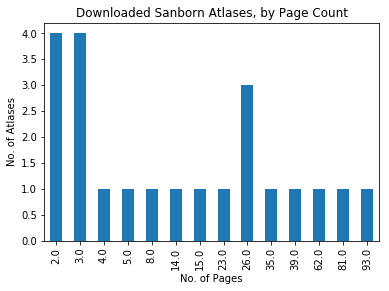

In [11]:
#Ignore any rows where page count is blank
page_count = metadata_dataframe[
        metadata_dataframe['page_count'].notnull()
    ].copy()
#Create the display
visualize = metadata_dataframe.page_count.groupby(
        page_count['page_count']
    ).count()
visualize.plot(kind="bar")
plt.title('Downloaded Sanborn Atlases, by Page Count')
plt.xlabel('No. of Pages')
plt.ylabel('No. of Atlases')
plt.show()

# 6. Metadata maps and Wikidata

<p class="lead">Let's get a larger set of metadata, and visualize it with a map and timeline. </p>

Python has many visualization modules that build on Matplotlib, such as Plotly. Let's use both to visualize information about Sanborn mapping of Illinois over time. 

Specifically, we'll:

1. get metadata from loc.gov for all of the Illinois Sanborn atlases online
2. get location information from Wikidata 
3. map the atlases, by county and publication year

To combine the loc.gov data with Wikidata data, we'll use something called a SPARQL query. 

<p class="lead">First, let's write a new function that gets metadata about Illinois Sanborns from loc.gov. </p>

For our location metadata, we need to get county names. In order to minimize the number of API requests we'll make, let's parse the county names from the `title` field rather than from the `location` metadata field. This will save us API requests, because we don't need to get each atlas's item record.  

However, it means we'll need to account for various types of "counties", as in these examples:

* "Belle Glade, Palm Beach County, Florida" (standard pattern)
* "Cape Girardeau, Cape Girardeau, Missouri" (counties missing the word "County")
* "Mankato, Blue Earth And Nicollet Counties, Minnesota" (two counties)
* "Kansas City, Jackson, Clay, And Platte Counties, Missouri" (three or more counties)
* "Saint Louis, Independent City, Missouri" (cities without counties)
* "New Orleans, Orleans Parish, Louisiana" (county-like entities)
* "Juneau, Juneau Census Division, Alaska" (county-like entities whose status has changed over time)


<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
define the `get_Sanborn_counties` function, which creates a dataframe of atlases based on an API query. Any atlas that is labelled with more than one county (or county-like entity) will have a row for each county. 
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;

</div>

In [12]:
'''Get atlases' location and date info from loc.gov'''
def get_Sanborn_counties(url,locations=[]):    
    params = {"fo": "json", "c": 200, "at": "results,pagination"}
    call = requests.get(url, params=params)
    #Check that the API request was successful.
    if (call.status_code==200) & ('json' in call.headers.get('content-type')):
        data = call.json()
        results = data['results']
        for result in results:
            #Try to extract the atlas year.
            try:
                date = result['date']
                year = date.split('-')[0]
                year = int(year)
            except:
                date = None
                year = None
            #Try to extract the city, county, and state from the title.
            try:
                title_location = result['title'].replace(
                    'Sanborn Fire Insurance Map from ',''
                )
            except:
                title_location = ''
            #Try to parse the city, county, and state info. 
            try:
                prep = re.split(', ',title_location)
                #The state will be at the end.
                state = prep[-1]
                state_clean = state.replace('.','')
                #The city will be at the beginning.
                city = prep[0]
                #The county will be in the middle.
                county_prep = prep[1:-1]
                county = ', '.join(county_prep)
                #Remove any county-like labels that might not be used today.
                try: 
                    county = county.replace(' Census Division','')
                except:
                    pass
                #Account for special circumstances
                two_counties = re.compile(
                    r"^(.+) and (.+) count(ies|y)$", 
                    re.IGNORECASE
                )
                if len(county_prep) == 1:
                    #Independent Cities: save the city as the county
                    if county == "Independent City":
                        location = {
                            'date':date,
                            'year':year,
                            'state':state_clean, 
                            'county':city, 
                            'city':city, 
                            'count':1
                        }
                        locations.append(location) 
                    #Two counties: split
                    elif re.match(two_counties, county):
                        county_1 = re.match(two_counties, county).groups()[0]
                        county_2 = re.match(two_counties, county).groups()[1]
                        location_1 = {
                            'date':date,
                            'year':year,
                            'state':state_clean, 
                            'county':county_1, 
                            'city':city, 
                            'count':1
                        }
                        location_2 = {
                            'date':date,
                            'year':year,
                            'state':state_clean, 
                            'county':county_2, 
                            'city':city, 
                            'count':1
                        }
                        locations.append(location_1)
                        locations.append(location_2)  
                    #"Normal" counties and unchanged county-like entities
                    else:
                        location = {
                            'date':date,
                            'year':year,
                            'state':state_clean, 
                            'county':county, 
                            'city':city, 
                            'count':1
                        }
                        locations.append(location)
                #Three or more counties: split
                elif len(county_prep)>1:
                    for x in range(0, len(county_prep)):
                        county_x = county_prep[x]
                        county_x = re.sub(r'[a|A]nd ','',county_x)
                        county_x = re.sub(' Counties','',county_x)
                        location = {
                            'date':date,
                            'year':year,
                            'state':state_clean, 
                            'county':county_x, 
                            'city':city,
                            'count':1
                        }
                        locations.append(location)
            #If city, county, state can't be parsed, warn the user.       
            except:
                print('Could not parse: ' + result['title'])
                print(county)
                print(county_prep)
        #Paginate through API query
        if data["pagination"]["next"] is not None:
            time.sleep(5)
            next_url = data["pagination"]["next"]
            get_Sanborn_counties(next_url,locations)
        else:
            print('done!')
        
        atlases_df=pd.DataFrame(locations)
        #Remove "County" from the county names, to assist Wikidata queries
        atlases_df['county'] = atlases_df['county'].str.replace(' County','')
        return atlases_df
    #If the API request failed, stop early and warn the user
    else:
        print('Stopping early\n')
        print('API request was unsuccessful: '+url+' Status was: '+str(call.status_code))
        print('Try running the cell again, or check your \"url\" variable.')
        if len(locations)>1:
            atlases_df=pd.DataFrame(locations)
            return atlases_df
        else:
            return None

<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
run the `get_Sanborn_counties` function to retrieve and clean metadata from loc.gov, for Illinois Sanborn atlases.

The output will be the dataframe `atlases_df`, and the first 6 lines will display.
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [13]:
url = 'https://www.loc.gov/collections/sanborn-maps/?fa=location:illinois'
atlases_df = get_Sanborn_counties(url)
atlases_df.head(6)
atlases_df['county'].replace(' County','',inplace=True)

done!


<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
view all of the unique county names in the `atlases_df` dataframe -- aka, Illinois counties with online Sanborn atlases.
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [14]:
for county in atlases_df.county.unique():
    print(county)

Knox
Edwards
Mercer
Warren
Effingham
Madison
Lee
Union
Lake
Douglas
Macon
Moultrie
Cass
Washington
Coles
Christian
Fulton
Menard
Logan
Piatt
Sangamon
Hancock
Kane
Jackson
Pike
Saint Clair
Boone
Macoupin
Dupage
Woodford
Franklin
Mcdonough
McLean
Grundy
Stark
Will
Clinton
Lawrence
Champaign
Edgar
Massac
Iroquois
Bureau
Ogle
Alexander
Henry
Adams
White
Saline
Greene
Williamson
Clark
Vermilion
Marion
Jefferson
Morgan
Livingston
Kankakee
Winnebago
Randolph
Cook
Peoria
Clay
De Witt
Monroe
Rock Island
McHenry
De Kalb
Tazewell
Perry
La Salle
Jo Daviess
Du Page
Jersey
Whiteside
Wayne
Fayette
Shelby
Stephenson
Ford
Pope
Pulaski
Cumberland
Bond
Mason
Putnam
Marshall
Montgomery
Carroll
Hamilton
Wabash
Brown
Johnson
Gallatin
Jasper
Crawford
Richland
Henderson
Kendall
Schuyler
Scott
Rock


<p class="lead">Great!</p>

Now we have a dataframe of all the Illinois Sanborn atlases, split up so that there is one row per county per atlas. 

In order to map data, mapping tools needs access to information about the counties' locations. There are lots of ways to get this information, and different types of location information we can get.

For one of our maps, we'll use a geojson file from Plotly that matches counties' "FIPS" codes with polygons (county borders). FIPS codes are used by the Census Bureau and other U.S. federal agencies to uniquely identify counties and county-like entities. For another map, we'll use coordinates for counties' center points. 

We'll go to Wikidata to get the necessary data: 
- county FIPS code 
- county coordinates, which contains the center point latitude and longitude

First, we need to reorganize our dataframe so that we have one row per county. To do this, we can use the Pandas function `.groupby()`.

<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
reorganize the `atlases_df` dataframe into a dataframe of counties, with one county per row, and save the new dataframe to `counties_df`. The `count` column will be the total count of atlases for that county.

The cell below will print the first 5 counties.
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [15]:
counties_df = atlases_df.groupby(['county', 'state']).agg({'count': 'sum'})
counties_df.reset_index(inplace=True)
counties_df.head(5)

,county,state,count
0,Adams,Illinois,14
1,Alexander,Illinois,8
2,Bond,Illinois,9
3,Boone,Illinois,6
4,Brown,Illinois,7


Next, we'll want to define a function to pull the FIPS codes and coordinates from Wikidata. We'll want to feed our `county` column to the function, and get three new columns in return:
1. `fips` - fips code
2. `lat` - latitude
3. `long` - longitude

Our function will use a SPARQL query to get this information from Wikidata.

<div class="alert alert-info">
<p class="lead">SPARQL queries</p>
    
A good starting point to learn about Wikidata SPARQL queries is the [Wikidata:SPARQL tutorial](https://www.wikidata.org/wiki/Wikidata:SPARQL_tutorial). SPARQL is an RDF query language broadly used for linked open data. 

</div>

<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
define the `get_fips_coords` function, which retrieves counties' FIPS codes and coordinates from Wikidata.
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [16]:
'''Get county fips codes and coordinates from Wikidata'''
def get_fips_coords(county,state):
    print('Getting info for: '+county + ', '+ state)
    #Insert county and state into the SPARQL query
    #using a particular format surrounded by quotes
    county = "\""+county+"\""
    state = "\""+state+"\""
    #Wikidata SPARQL query base
    url = 'https://query.wikidata.org/sparql'
    try:
        #Define the SPARQL query
        query = """
        SELECT DISTINCT
        ?countyLabel ?stateLabel ?fips ?coordinates
        WHERE {
          ?state rdfs:label """+state+"""@en.
          ?county wdt:P131 ?state;
                  rdfs:label ?countyname;
                  wdt:P882 ?fips;
                  wdt:P625 ?coordinates.
          FILTER contains(?countyname,"""+county+""").

          SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
        }
        """
        #Run the SPARQL query
        call = requests.get(url, params = {'format': 'json', 'query': query})
        #If Wikidata warns that you're requesting too much, pause and retry once.
        if call.status_code == 429:
            time.sleep(5) 
            call = requests.get(url, params = {'format': 'json', 'query': query})
        else:
            pass
        #If the retry works, proceed.     
        if (call.status_code == 200) & \
          ('json' in call.headers.get('content-type')):
            data = call.json()
            try:
                coordinates = \
                    data['results']['bindings'][0]['coordinates']['value']
                lon = re.match(r"Point\((.+) (.+)\)", coordinates).groups()[0]
                lat = re.match(r"Point\((.+) (.+)\)", coordinates).groups()[1]
            except:
                lat = None
                lon = None
            try:
                fips = data['results']['bindings'][0]['fips']['value']
            except:
                fips = None
        #If you had to retry and it didn't work, 
        #Or if server could not provide result for any other reason,
        # give up and record as not found.
        else:
            print('Problem encountered with: ' + county + ', ' + state)
            time.sleep(12)
            fips = None
            lat = None
            lon = None
    #If request failed for any other reason, record as not found.
    except:
        fips = None
        lat = None
        lon = None
    time.sleep(.4)
    return fips, lat, lon

Querying Wikidata can be a little slow. When you're ready to start, kick off the cell below. It may take a few minutes to finish, depending on your internet connection and Wikidata's response speed. 

<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
get county FIPS codes and coordinates from Wikidata, and merge this infomration back into the `counties_by_year` dataframe. Returns out a sample of 5 rows. 
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [17]:
#Query Wikidata for FIPS and coordinates.
counties_df['fips'],counties_df['lat'],counties_df['long'] = \
    zip(
        *counties_df.apply(
            lambda df: get_fips_coords(df.county, df.state), axis=1
        )
    )

#Group and count atlases by county, state, and year
counties_by_year = atlases_df.groupby(
        ['county', 'state','year']
    ).agg({'count': 'sum'})
counties_by_year.reset_index(inplace=True)

#Add the Wikidata columns onto "counties_by_year"
counties_by_year = pd.merge(
    counties_by_year,
    counties_df,
    how="left",
    on=['county','state'],
    suffixes=('', '_bycounty'),
)

#Sort by year,
counties_by_year.sort_values('year', inplace=True)

#Standardize numerical data formats 
counties_by_year['lat'] = counties_by_year.lat.astype(float)
counties_by_year['long'] = counties_by_year.long.astype(float)
counties_by_year['count'] = counties_by_year['count'].astype(int)

#Display results
counties_by_year

Getting info for: Adams, Illinois
Getting info for: Alexander, Illinois
Getting info for: Bond, Illinois
Getting info for: Boone, Illinois
Getting info for: Brown, Illinois
Getting info for: Bureau, Illinois
Getting info for: Carroll, Illinois
Getting info for: Cass, Illinois
Getting info for: Champaign, Illinois
Getting info for: Christian, Illinois
Getting info for: Clark, Illinois
Getting info for: Clay, Illinois
Getting info for: Clinton, Illinois
Getting info for: Coles, Illinois
Getting info for: Cook, Illinois
Getting info for: Crawford, Illinois
Getting info for: Cumberland, Illinois
Getting info for: De Kalb, Illinois
Getting info for: De Witt, Illinois
Getting info for: Douglas, Illinois
Getting info for: Du Page, Illinois
Getting info for: Dupage, Illinois
Getting info for: Edgar, Illinois
Getting info for: Edwards, Illinois
Getting info for: Effingham, Illinois
Getting info for: Fayette, Illinois
Getting info for: Ford, Illinois
Getting info for: Franklin, Illinois
Getting 

,county,state,year,count,count_bycounty,fips,lat,long
0,Adams,Illinois,1883,1,14,17001,39.990000,-91.190000
144,Cook,Illinois,1883,1,123,17031,41.800000,-87.716667
1010,Vermilion,Illinois,1884,1,30,17183,40.180000,-87.740000
604,Logan,Illinois,1884,1,16,17107,40.130000,-89.360000
905,Saint Clair,Illinois,1884,2,44,17163,38.470000,-89.930000
935,Sangamon,Illinois,1884,1,25,17167,39.760000,-89.660000
1071,Whiteside,Illinois,1884,3,25,17195,41.750000,-89.910000
259,Edgar,Illinois,1884,1,16,17045,39.680000,-87.750000
36,Bureau,Illinois,1885,1,35,17011,41.410000,-89.530000
760,Mercer,Illinois,1885,1,13,17131,41.200000,-90.740000


## Clean up the data and map it!
<p class="lead">Now we have the FIPS codes and coordinates from Wikidata.</p>

Scroll to the bottom of the results above to look at the dataframe table. 

Notice Cook county high on the list? Chicago is in Cook County, which explains why the `county_bycounty` value (123) is so high. `county_bycounty` is the total number of online atlase volumes for Cook county across all years.

<p class="lead">Our data is ready for mapping.</p>
  
First, let's make what's called a choropleth map, where Illinois's counties are colored according to how many atlas volumes are online for that county. This visualization relies on the FIPS codes we pulled from Wikidata. 

<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
generate a choropleth map of all Illinois Sanborn atlases online at loc.gov, by county.

(Tip: zoom in to get a closer look at Illinois!)
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>


In [ ]:
#Retrieve Plotly's geojson file, which matches county FIPS codes with county polygons
geojson = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
with urlopen(geojson) as response:
    counties = json.load(response)
    
fig = px.choropleth(
        counties_df, 
        title = 'Sanborn atlas volumes online, by County (Illinois)',
        hover_name='county', hover_data=['state', 'count'],
        geojson=counties, locations='fips', 
        color='count',
        color_continuous_scale=['#e6eff7','#005fa8'],
        range_color=(0, 100),
        scope="usa",
        labels={'count':'Atlas count'}
      )
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0})
fig.show()

<p class="lead">Next, let's make a proportional dot map, with a timeline at the bottom. </p>

This visualization relies on the coordinates we pulled from Wikidata. 

<div class="alert alert-success">

<p class="lead"> Run the next cell to: </p> 
    
generate a timeline map showing the number of Illinois Sanborn atlases online at loc.gov, by county and year.
    
&#8595; &#8595; &#8595; &#8595; &#8595; &#8595;
</div>

In [ ]:
#Customize the figure 
fig = px.scatter_mapbox(
        counties_by_year, 
        title = 'Sanborn atlas volumes online, by County and Year (Illinois)',
        lat='lat', lon='long', 
        hover_name='county', hover_data=['state', 'count'],
        size='count',
        color_discrete_sequence=["fuchsia"],
        animation_frame='year',
        height=440, zoom=4,
        center = {'lat':40,'lon':-88.8}
    )
#Use OpenStreetMap as the base layer
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0})
fig.show()

<div class="alert alert-info">
<p class="lead">Tip</p>
    
Press play on the timeline, or pull the timeline to see atlases published by year.

Atlases with publication dates in the mid-20th century are usually atlases originally published earlier, with updates later added. 


</div>